#CISC372 Final Project
###Editor: Shuyang Wang
###Student ID: 20114447
###Date: 2022-04-22

In [2]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 5.1 MB/s 


In [3]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
# load recruitment
from pandas import read_csv
from matplotlib import pyplot

# load data 
# Campus recruitment 
recruitment_path = 'https://raw.githubusercontent.com/ShuyangWang218/queensCISC372/main/Placement_Data_Full_Class.csv'

# use column ds as index 
recruitment = read_csv(recruitment_path, header=0, index_col=0)
#recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 1 to 215
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 25.2+ KB


In [ ]:
#load admission file
admission_path = 'https://raw.githubusercontent.com/ShuyangWang218/queensCISC372/main/Admission_Predict.csv'

# use column ds as index 
admission = read_csv(admission_path, header=0, index_col=0)
#admission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          400 non-null    int64  
 1   TOEFL Score        400 non-null    int64  
 2   University Rating  400 non-null    int64  
 3   SOP                400 non-null    float64
 4   LOR                400 non-null    float64
 5   CGPA               400 non-null    float64
 6   Research           400 non-null    int64  
 7   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 28.1 KB


In [ ]:
#load job file
job_path = 'https://raw.githubusercontent.com/ShuyangWang218/queensCISC372/main/aug_train.csv'

# use column ds as index 
job = read_csv(job_path, header=0)
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
job.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [55]:
#job.education_level.unique()
job.describe()
#job.city.unique()
#job.company_type.unique()

,enrollee_id,city_development_index
count,19158.000000,19158.000000
mean,16875.358179,0.828848
std,9616.292592,0.123362
min,1.000000,0.448000
25%,8554.250000,0.740000
50%,16982.500000,0.903000
75%,25169.750000,0.920000
max,33380.000000,0.949000


#Proprocessing

In [4]:
#load job file
from pandas import read_csv
job_path = 'https://raw.githubusercontent.com/ShuyangWang218/queensCISC372/main/aug_train.csv'

#drop irrelevant columns
job = read_csv(job_path, header=0)
job = job.drop(columns=['company_size', 'target', 'training_hours']) 

#training data have not null company type.
train = job.loc[~job['company_type'].isna()]
X_train = train.drop(columns=['company_type']) 
y_train = train[['company_type']]

#test data have null company type.
test = job.loc[job['company_type'].isna()]
X_test = test.drop(columns=['company_type']) 

In [ ]:
print("Missing values in the train dataset:\n\n",job.isna().sum())
print("Missing values in the train dataset:\n\n",train.isna().sum())

Missing values in the train dataset:

 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_type              6140
last_new_job               423
dtype: int64
Missing values in the train dataset:

 enrollee_id                  0
city                         0
city_development_index       0
gender                    2801
relevent_experience          0
enrolled_university        144
education_level            159
major_discipline          1164
experience                  29
company_type                 0
last_new_job               182
dtype: int64


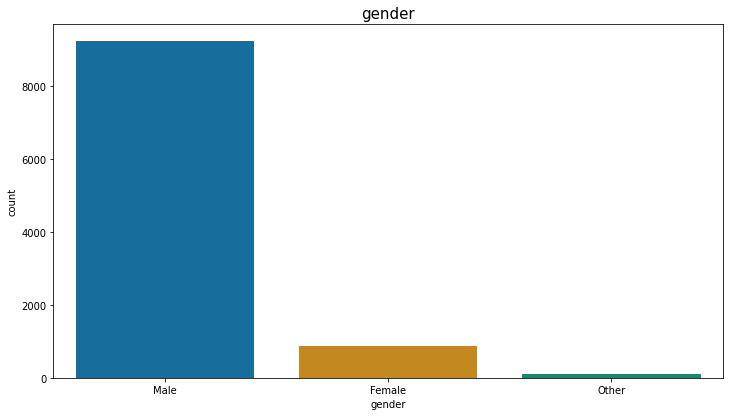

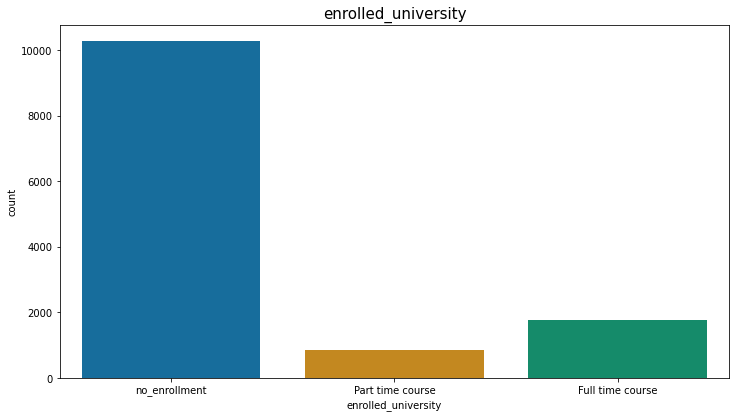

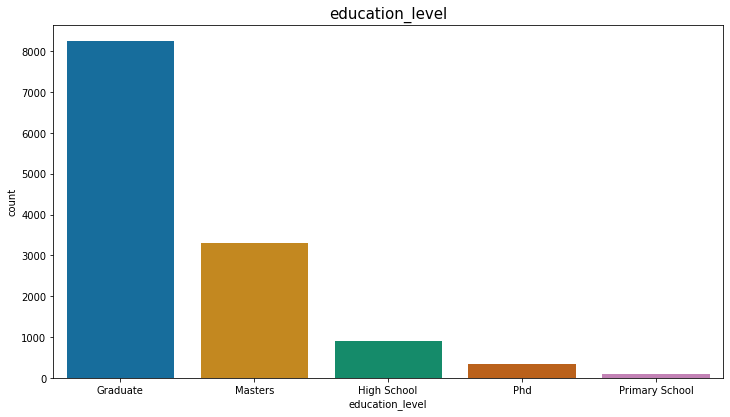

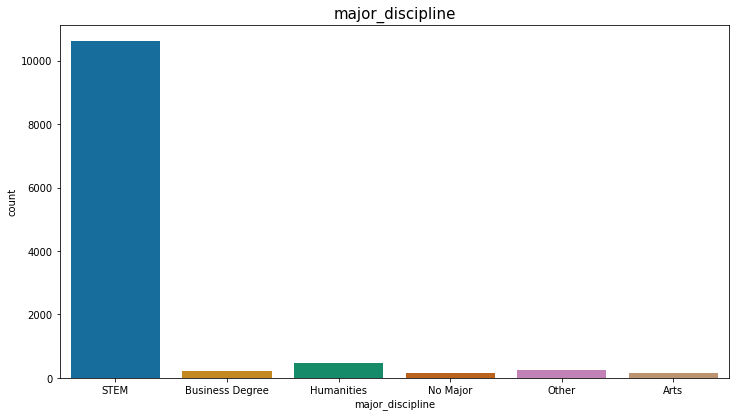

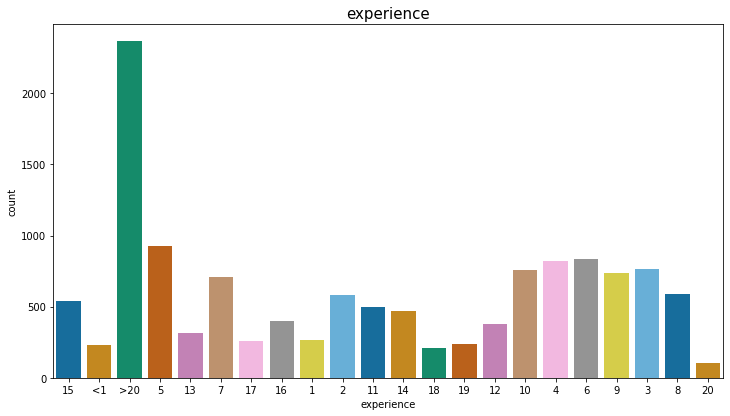

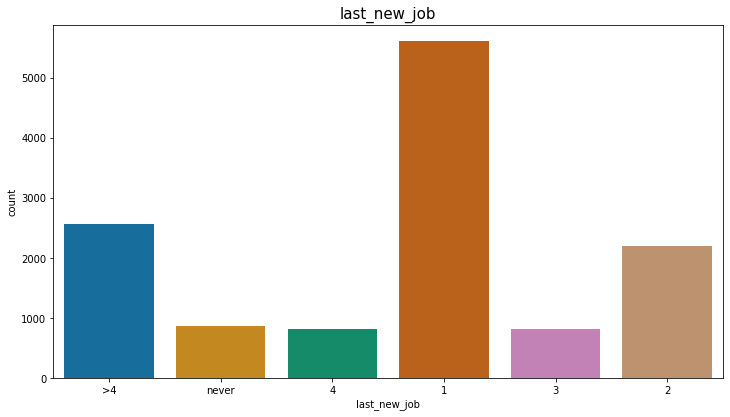

In [ ]:
#Plot variables with NAN
import seaborn as sns 
cols_with_nan_data = train[['gender', 'enrolled_university', 'education_level', 'major_discipline', 
                                 'experience', 'last_new_job']]   
colorblind_palette = sns.color_palette("colorblind")

for i in cols_with_nan_data:
    plt.figure(figsize=(12,6.5)) 
    plt.title(i, fontsize=15, ha='center')
    sns.countplot(data = train[i], x = cols_with_nan_data[i], palette=colorblind_palette)
    plt.show()

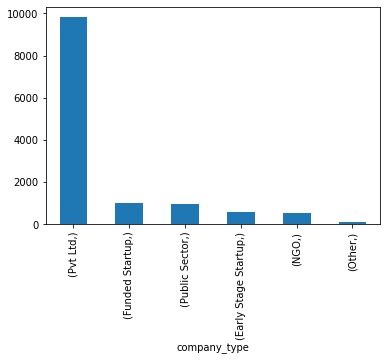

In [ ]:
#Plot target variable
y_train.value_counts().plot(kind='bar')

In [5]:
#split training data into training data and dev data.
X_train,X_dev,y_train,y_dev = train_test_split(X_train, y_train,test_size=0.3,stratify=y_train,random_state=42)

print("Shape of training data:\n\n", X_train.shape, y_train.shape)
print("\n\nShape of dev data:\n\n", X_dev.shape, y_dev.shape)
print("\n\nShape of test data:\n\n", X_test.shape)

Shape of training data:

 (9112, 10) (9112, 1)


Shape of dev data:

 (3906, 10) (3906, 1)


Shape of test data:

 (6140, 10)


In [ ]:
#X_train.head(), X_test.head(), y_train.head(), X_test.head()
#test.head(10)
train.company_type.describe()

count       13018
unique          6
top       Pvt Ltd
freq         9817
Name: company_type, dtype: object

In [ ]:
train.describe()
#test.head(10)

,enrollee_id,city_development_index
count,13018.000000,13018.000000
mean,16552.111692,0.834931
std,9815.237902,0.121249
min,1.000000,0.448000
25%,7961.250000,0.754000
50%,16412.500000,0.910000
75%,25188.500000,0.920000
max,33380.000000,0.949000


In [6]:
# model training and tuning
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

# A random number generator 
# It ensures the replicability of the result and aviods seeing the entire dataset over time.
np.random.seed(0) 

# Create a pipeline for processing numerical features -
# SimpleImputer replaces missing values using the median along each column.
# StandardScaler standardize the dataset to let it have 0 mean and unit variance.
# Assembling multiple steps indeed simplify and organize the pre-precessing process 


numeric_features = ['enrollee_id', 'city_development_index']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Create a pipeline for processing categorical variables -
# Repace missing value by the mode and encode features as one-hot numeric arrays.

ordinal_features = ['education_level', 'experience', 'last_new_job']
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OrdinalEncoder',OrdinalEncoder(categories=[
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))])



nominal_features = ['city',  'gender', 'relevent_experience', 
                      'enrolled_university', 'major_discipline']                        
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Apply numeric_transformer ordinal_features and cardinal_transformer to different transformers, respectively.
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
                                  ('ord', ordinal_transformer, ordinal_features),
                                  ('card', nominal_transformer, nominal_features)])


# Select out the needed columns
X_train = X_train[[*numeric_features, *ordinal_features, *nominal_features]]
X_dev = X_dev[[*numeric_features, *ordinal_features, *nominal_features]]
X_test = X_test[[*numeric_features, *ordinal_features, *nominal_features]]


# SVM

In [56]:
# A pipeline for regression: conduct preprocessing at first, and then run classification.
# Uncomment regr and param_grid of the specific algorithm and comment out the others to implement 
# XGB classification, logistic regression, or SVM.

# SVC
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', SVC())])


# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)

# Parameter grid for SVC
'''
    {'regressor__kernel': ['linear'],
    'regressor__C': [0.01, 0.1, 0.5],
    'regressor__max_iter': [2000]
     },
'''
param_grid = [

    {'regressor__kernel': ['rbf', 'sigmoid'],
    'regressor__C': [0.01, 0.1, 0.5],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__max_iter': [2000]
     },
    {'regressor__kernel': ['poly'],
    'regressor__C': [0.01, 0.1, 0.5],
    'regressor__degree': [2, 3, 4],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__max_iter': [2000]
     }
]


### Randomized Search
- Training f1: 0.648
- Testing f1 0.649
- Time: 2m1s

#XGBoost - Tune n_estimators

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 500, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', XGBClassifier(**other_params,
                          objective='multi:softmax'))])

# Parameter grid for XGBoost classification
param_grid = {
    'regressor__n_estimators': np.linspace(550, 650, 11, dtype=int)
}
#'regressor__n_estimators': np.linspace(100, 1000, 10, dtype=int),
#'regressor__n_estimators': np.linspace(50, 150, 11, dtype=int)

### Randomized Search
- Training f1: 0.667
- Time: 14m18s
- Best Parameter: {'regressor__n_estimators': 570}

#XGBoost - Tune max_depth

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__max_depth': np.linspace(1, 10, 10, dtype=int)
}

### Grid Search
- Training f1: 0.757
- Dev f1: 0.658
- Time: 2m22s
- Best Parameter: {'regressor__max_depth': 2}

#XGBoost - Tune min_child_weight

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0, 'max_depth': 2, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__7': np.linspace(1, 10, 10, dtype=int)
}

### Grid Search
- Training f1: 0.758
- Dev f1: 0.665
- Time: 1m22s
- Best Parameter: {'regressor__min_child_weight': 7}

#XGBoost - Tune gamma

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0, 'max_depth': 2, 'min_child_weight': 7,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__gamma': np.linspace(0, 1, 21)
}
#'clf__gamma': np.linspace(0, 1, 21)
#'clf__gamma': np.linspace(0.05, 0.15, 11)

### Grid Search
- Training f1: 0.757
- Dev f1: 0.666
- Time: 2m48s
- Best Parameter: {'regressor__gamma': 0.1}

#XGBoost - Tune subsample

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0.1, 'max_depth': 2, 'min_child_weight': 7,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__subsample': np.linspace(0, 1, 11)
}
#'clf__subsample': np.linspace(0.25, 0.35, 11)
#'clf__subsample': np.linspace(0, 1, 11)


### Grid Search
- Training f1: 0.758
- Dev f1: 0.666
- Time: 1m31s
- Best Parameter: {'regressor__subsample': 0.3}

#XGBoost - Tune colsample_bytree

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0.1, 'max_depth': 2, 'min_child_weight': 7,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 0.3, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__colsample_bytree': np.linspace(0.1, 1, 10)
}

### Grid Search
- Training f1: 0.759
- Dev f1: 0.664
- Time: 1m3s
- Best Parameter: {'regressor__colsample_bytree': 0.7}

#XGBoost - reg_lambda

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0.1, 'max_depth': 2, 'min_child_weight': 7,
                'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 0.3, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__colsample_bytree': [0.7, 1],
    'clf__reg_lambda': np.linspace(30, 50, 11)
}
#'clf__reg_lambda': np.linspace(0, 100, 11)
#'clf__reg_lambda': np.linspace(40, 60, 11)

### Grid Search
- Training f1: 0.758
- Dev f1: 0.664
- Time: 2m48s
- Best Parameter: {'reg_lambda': 0.1}

#XGBoost - reg_alpha

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0.1, 'max_depth': 2, 'min_child_weight': 7,
                'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 0.3, 'reg_lambda': 40, 'reg_alpha': 0,
                'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__reg_alpha': np.linspace(3.5, 4.5, 11)
}
#'clf__reg_alpha': np.linspace(0, 10, 11)
#'clf__reg_alpha': np.linspace(0, 10, 11)

### Grid Search
- Training f1: 0.759
- Dev f1: 0.666
- Time: 1m22s
- Best Parameter: {'reg_alpha': 0.41}

#XGBoost - eta

In [ ]:
# XGBoost
other_params = {'eta': 0.3, 'n_estimators': 570, 'gamma': 0.1, 'max_depth': 2
                , 'min_child_weight': 7,'colsample_bytree': 0.7, 'colsample_bylevel': 1,
                'subsample': 0.3, 'reg_lambda': 40, 'reg_alpha': 0.41, 'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__eta': np.logspace(-2, 0, 10)
}

### Grid Search
- Training f1: 0.759
- Dev f1: 0.666
- Time: 1m21s
- Best Parameter: {'eta': 0.01}

#XGBoost -  overall

In [ ]:
# XGBoost
other_params = {'n_estimators': 570, 'max_depth': 2, 'min_child_weight': 7,
                'colsample_bylevel': 1, 'seed': 33}

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Parameter grid for XGBoost classification
param_grid = {
    'clf__gamma': [0.1, 0.22222222],
    'clf__subsample': [0.3, 0.34, 1],
    'clf__colsample_bytree': [0.7, 1],
    'clf__reg_lambda': [1, 38, 40],
    'clf__reg_alpha': [4, 4.1],
    'clf__eta': [0.01,  0.3]
}

### Bayesian Search
- Training f1: 0.664
- Dev f1: 0.666
- Time: 8m32s

#Neural Network - Trial 1

In [ ]:
from sklearn.neural_network import MLPClassifier

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', MLPClassifier(alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1, verbose=False))])

# Parameter grid for XGBoost classification
param_grid = [
    {'regressor__solver': ['lbfgs','adam'],
    'regressor__activation':['logistic', 'tanh'],
     },
    {'regressor__solver': ['sgd'],
    'regressor__activation':['logistic', 'tanh'],
    'regressor__learning_rate': ['invscaling', 'adaptive']
     }
]

### Bayesian Search
- Training f1: 0.662
- Dev f1: 0.667
- Time: 37m12s
- Best parameters: ('regressor__activation', 'tanh'), ('regressor__solver', 'lbfgs')

#Neural Network - Trial 2

In [164]:
from sklearn.neural_network import MLPClassifier

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', MLPClassifier())])

# Parameter grid for XGBoost classification
param_grid = [
    {'regressor__solver': ['lbfgs'],
    'regressor__activation':['tanh'],
    'regressor__alpha': [1e-6, 1e-5, 1e-4],
    'regressor__warm_start': [True, False],
     }
]

'''
param_grid = [
    {'regressor__solver': ['lbfgs'],
    'regressor__activation':['logistic', 'tanh'],
    'regressor__alpha': [1e-6, 1e-5, 1e-4],
    'regressor__warm_start': [True, False],
    'regressor__hidden_layer_sizes': [(100,), (200,), (300,), (400,), (500,)]
     }
]
'''

"\nparam_grid = [\n    {'regressor__solver': ['lbfgs'],\n    'regressor__activation':['logistic', 'tanh'],\n    'regressor__alpha': [1e-6, 1e-5, 1e-4],\n    'regressor__warm_start': [True, False],\n    'regressor__hidden_layer_sizes': [(100,), (200,), (300,), (400,), (500,)]\n     }\n]\n"

### Bayesian Search
- Training f1: 0.665
- Dev f1: 0.664
- Time: 36m53s
- Best parameters: ('regressor__activation', 'tanh'), ('regressor__alpha', 0.0001), ('regressor__solver', 'lbfgs'), ('regressor__warm_start', False)


best training score: 
	0.6647990598521156
best dev score: 
	0.6635618171450973
best parameters: 
	OrderedDict([])

#Neural Network - Trial 3

In [167]:
from sklearn.neural_network import MLPClassifier

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', MLPClassifier())])

# Parameter grid for XGBoost classification
param_grid = [
    {'regressor__solver': ['lbfgs'],
    'regressor__activation':['logistic'],
    'regressor__alpha': [1e-6, 1e-5, 1e-4],
    'regressor__warm_start': [True, False],
     }
]


### Bayesian Search
- Training f1: 0.664
- Dev f1: 0.663
- Time: 33m29s
- Best parameters: ('regressor__activation', 'logistic'), ('regressor__alpha', 1e-05), ('regressor__solver', 'lbfgs'), ('regressor__warm_start', False)

best training score: 
	0.6638843755121162
best dev score: 
	0.6631974905313086
best parameters: 
	OrderedDict([])

#Final Model - neural network

In [7]:
from sklearn.neural_network import MLPClassifier

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', MLPClassifier(alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1, verbose=False))])

# Parameter grid for XGBoost classification
param_grid = [
    {'regressor__solver': ['lbfgs'],
    'regressor__activation':['tanh'],
     }
]

#Grid Search 

In [ ]:
# Exhaustive search over specified parameter values for an estimator.
# This funtion tunes the hyper-parameters to achieve the best accuracy. 
grid_search = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='f1_micro')
grid_search.fit(X_train, y_train)

print('best score {}'.format(grid_search.best_score_))
print('best parameter {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score 0.7574626088286458
best parameter {'clf__gamma': 0.1}


In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([3.01612086, 3.11028428, 2.99611688, 3.67113109, 3.51687999,
        3.76781869, 3.04123116, 3.49994645, 3.39228945, 2.98437266,
        2.99694581, 3.26453614, 2.98904634, 3.00129185, 2.97473173,
        2.98603601, 2.97852373, 2.96285706, 2.96240082, 2.96092014,
        2.81848178]),
 'mean_score_time': array([0.10913191, 0.11573091, 0.10977559, 0.17917285, 0.10695715,
        0.12975755, 0.10812378, 0.16439824, 0.10846539, 0.1079761 ,
        0.10783262, 0.10713949, 0.11129303, 0.10761728, 0.10632577,
        0.10723572, 0.10461087, 0.10458689, 0.10345345, 0.1049118 ,
        0.09469924]),
 'mean_test_score': array([0.75724307, 0.75724307, 0.75746261, 0.75702353, 0.75746255,
        0.7571333 , 0.75724307, 0.75691382, 0.75724307, 0.75702359,
        0.75735278, 0.75702365, 0.75702353, 0.7571333 , 0.7571333 ,
        0.7571333 , 0.75724301, 0.75735278, 0.75724301, 0.7571333 ,
        0.75735278]),
 'param_clf__gamma': masked_array(data=[0.0, 0.05, 0.1, 0.15000

In [ ]:
# Prediction
y_pred = grid_search.predict(X_dev)
f1_score(y_dev, y_pred, zero_division=1, average = 'weighted')

0.6655718319669041

#Randomized Search 

In [57]:
# Alternatively, we can try randomized search to tune hyperparameters.
random_grid = RandomizedSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='f1_weighted')
random_grid.fit(X_train, y_train)

print()
print('best score {}'.format(random_grid.best_score_))
print()
print('best parameter {}'.format(random_grid.best_params_))
#random_grid.best_params_, random_grid.best_score_ #, random_grid.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



best score 0.6483326712661304

best parameter {'regressor__max_iter': 2000, 'regressor__kernel': 'poly', 'regressor__gamma': 'scale', 'regressor__degree': 3, 'regressor__C': 0.1}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [ ]:
random_grid.cv_results_

{'mean_fit_time': array([3.19739671, 2.62616873, 2.68696699, 3.0905272 , 2.78362889,
        3.33008237, 2.78839326, 3.08914595, 3.29736905, 2.55064344]),
 'mean_score_time': array([0.10971708, 0.11081986, 0.11293788, 0.10551434, 0.11205573,
        0.11178241, 0.11395893, 0.10878105, 0.11378808, 0.09977689]),
 'mean_test_score': array([0.65206985, 0.65872225, 0.65120624, 0.66036998, 0.65179748,
        0.66044082, 0.65204376, 0.66030125, 0.65277657, 0.65852214]),
 'param_clf__colsample_bytree': masked_array(data=[1, 0.7, 0.7, 1, 0.7, 1, 0.7, 1, 1, 0.7],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__eta': masked_array(data=[0.3, 0.3, 0.01, 0.01, 0.01, 0.01, 0.3, 0.01, 0.01, 0.3],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__gamma

In [ ]:
# Prediction
y_pred = random_grid.predict(X_dev)
f1_score(y_dev, y_pred, zero_division=1, average = 'weighted')

0.6624161497533824

#Bayesian Search 

In [8]:
from skopt import BayesSearchCV

bayesian_grid = BayesSearchCV(
    regr, param_grid, cv=5, verbose=0, n_jobs=2, 
    scoring='f1_weighted')

bayesian_grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['enrollee_id',
                                                                           'city_development_index']),
                                                                         ('ord',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('OrdinalEncoder',
           

In [9]:
from sklearn.metrics import accuracy_score, f1_score

print('best training score: \n\t{}'.format(bayesian_grid.best_score_))
# Prediction & generating the submission file
y_pred = bayesian_grid.predict(X_dev)
#pd.DataFrame(
#    {'Id': enrollee_id, 'price_rating':y_pred}).to_csv('svm_submission.csv', index=False)
dev = f1_score(y_dev, y_pred, zero_division=1, average = 'weighted')
print('best dev score: \n\t{}'.format(dev))
print('best parameters: \n\t{}'.format(bayesian_grid.best_params_))

best training score: 
	0.6623779079083982
best dev score: 
	0.6674029364756948
best parameters: 
	OrderedDict([('regressor__activation', 'tanh'), ('regressor__solver', 'lbfgs')])


#Predict the test data

In [10]:
# Prediction
y_test = bayesian_grid.predict(X_test)


In [32]:
from sklearn.inspection import permutation_importance

#importance of factors
r = permutation_importance(bayesian_grid, X_dev, y_dev, n_repeats=30, random_state=0)

In [53]:
r = permutation_importance(bayesian_grid, 
                           X_dev.loc[(X_dev['education_level']=='Graduate') & (X_dev['experience'].isin('<1,1,2,3,4,5'.split(',')))], 
                           y = y_dev.loc[(X_dev['education_level']=='Graduate') & (X_dev['experience'].isin('<1,1,2,3,4,5'.split(',')))], 
                           n_repeats=30, random_state=0)

In [45]:
'<1,1,2,3,4,5'.split(',')

['<1', '1', '2', '3', '4', '5']

In [54]:
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print("*"f"{[*numeric_features, *ordinal_features, *nominal_features][i]:<8}""\t\t"               
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")
  else:
    print(f"{[*numeric_features, *ordinal_features, *nominal_features][i]:<8}""\t\t"               
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

*enrolled_university		0.018 +/- 0.004
*city    		0.017 +/- 0.006
*relevent_experience		0.016 +/- 0.005
city_development_index		0.006 +/- 0.004
last_new_job		0.003 +/- 0.003
*gender  		0.003 +/- 0.001
major_discipline		0.003 +/- 0.002
enrollee_id		0.001 +/- 0.001
experience		0.000 +/- 0.000
education_level		0.000 +/- 0.000


In [61]:
y_pred = random_grid.predict(X_test)
X_test['company_type'] = y_pred
X_test.head()

,enrollee_id,city_development_index,education_level,experience,last_new_job,city,gender,relevent_experience,enrolled_university,major_discipline,company_type
0,8949,0.920,Graduate,>20,1,city_103,Male,Has relevent experience,no_enrollment,STEM,Pvt Ltd
2,11561,0.624,Graduate,5,never,city_21,NaN,No relevent experience,Full time course,STEM,Pvt Ltd
5,21651,0.764,Graduate,11,1,city_176,NaN,Has relevent experience,Part time course,STEM,Pvt Ltd
10,29452,0.624,High School,2,never,city_21,NaN,No relevent experience,Full time course,NaN,Pvt Ltd
13,5826,0.624,NaN,2,never,city_21,Male,No relevent experience,NaN,NaN,Pvt Ltd


In [66]:
X_test[['enrollee_id','company_type']].head()

,enrollee_id,company_type
0,8949,Pvt Ltd
2,11561,Pvt Ltd
5,21651,Pvt Ltd
10,29452,Pvt Ltd
13,5826,Pvt Ltd


In [62]:
pd.DataFrame(
    {'enrollee_id': X_test['enrollee_id'], 'company_type':y_pred}).to_csv('final_prediction.csv', index=False)